# Exercise 5 - SVM and Kernel Trick

In this exercise you will implement a Support Vector Machine and improve its performance by using the famous kernel trick.

### Submission

- Deadline of submission:
        x.y.z
- Mail your solution notebook or a link to your gitlab repository (with the solution notebook inside) to:
        paul.kahlmeyer@uni-jena.de

In the event of a persistent problem, do not hesitate to contact the course instructors.

# The Dataset

In this exercise we are using a toy [circle dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles) from scikit learn

### Task 1
The dataset is stored as numpy arrays under `X.npy` (images) and `Y.npy` (labels).

Load the dataset and display it using matplotlib.

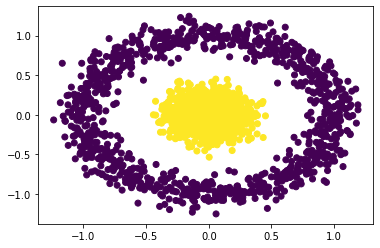

In [1]:
# TODO: load and visualize data
import numpy as np
import matplotlib.pyplot as plt

X = np.load('X.npy')
Y = np.load('Y.npy')

plt.scatter(X[:,0], X[:,1], c=Y)

Each feature in this dataset has one of two possible labels. 
The standard approach for binary classification tasks is logistic regression.

### Task 2
Use scikit learn to fit logistic regression on the dataset. What is the train- and test accuracy?

In [2]:
# TODO: apply logistic regression on data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
regressor =  LogisticRegression()

regressor.fit(X_train, Y_train)
train_acc = np.mean(regressor.predict(X_train)==Y_train)
test_acc = np.mean(regressor.predict(X_test)==Y_test)

print(f'Test Accuracy: {test_acc}\tTrain Accuracy: {train_acc}')

Test Accuracy: 0.638	Train Accuracy: 0.674


### Task 3

Visualize the predictions made with logistic regression in order to get an understanding on the results.

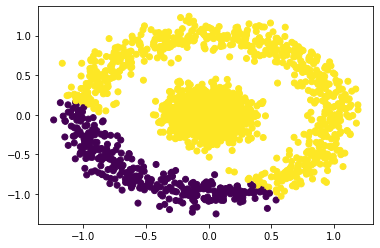

In [3]:
# TODO: visualize predictions
Y_pred = regressor.predict(X)
plt.scatter(X[:,0], X[:,1], c=Y_pred)

# SVM

Support Vector Machines (SVMs) are using the Kernel Trick to find a linear classifier in a higher dimension (see Lecture Notes).

The standard soft margin support vector machine is defined by the loss function
\begin{align}
L = \cfrac{1}{2}||\theta||^2+C\sum_{i=1}^m\max\{1-y^{(i)}(\theta^Tx^{(i)}), 0\}
\end{align}

We can use the fact, that $\theta$ is a linear combination of our datapoints
\begin{align}
\theta = \sum_{i=1}^m w_i x^{(i)}
\end{align}

to rewrite the objective function as
\begin{align}
L = \cfrac{1}{2}w^TXX^Tw+C\sum_{i=1}^m\max\{1-y^{(i)}(w^TXx^{(i)}+b), 0\}\,.
\end{align}

Note that the labels $y^{(i)}$ have to be binary in $\{-1,1\}$.

This loss function relies on the dot product as a measure of similarity between two vectors.
For two matrices $X_1, X_2\in\mathbb{R^{m\times d}}$, we can get the matrix of pairwise similarity with
\begin{align}
Sim(X_1, X_2) = X_1X_2^T
\end{align}

### Task 4

Create a Train- and Testset for SVM and implement the pairwise similarity function.

In [4]:
# TODO: Create Train- and Testset
X_train_svm = X_train
X_test_svm = X_test
Y_train_svm = Y_train*2-1
Y_test_svm = Y_test*2-1

def sim(X1, X2):
    # TODO: Implement similarity function between two sets of vectors
    return (X1 @ X2.T)

Lets have a closer look at the second part of our cost function $L$:

The innermost component 

\begin{align}
Dec(x^{(i)}):= w^TXx^{(i)}+b
\end{align}

produces a *decision* of the SVM that can be used for a *prediction*

\begin{align}
\hat{y}^{(i)}=Pred(x^{(i)}) := \begin{cases}
1\text{, if }Dec(x^{(i)})\geq 0\\
-1\text{, else}
\end{cases}
\end{align}

for the label $y^{(i)}$ of the feature $x^{(i)}$.

Next, we multiply this decision with the true label. 
\begin{align}
Marg(x^{(i)}):=y^{(i)}(w^TXx^{(i)}+b)
\end{align}

This term is called *margin*.

Recall, that our true labels are $\in\{-1,1\}$. Therefore
\begin{align}
\max\{1-Marg(x^{(i)}), 0\} = \begin{cases}
0\text{, if }sign(Dec(x^{(i)}))=sign(y^{(i)})\text{ and }|Dec(x^{(i)})|\geq 1\\
\in(0,1]\text{, if }sign(Dec(x^{(i)}))=sign(y^{(i)})\text{ and }|Dec(x^{(i)})|< 1\\
\in(1,\infty)\text{, if }sign(Dec(x^{(i)}))\neq sign(y^{(i)})
\end{cases}
\end{align}

gives us a measure on the error we made with a decision. The term

\begin{align}
\xi_i := 1-Marg(x^{(i)})
\end{align}
is called *slack*.

Note, that we use a corpus of features $X$ (our trainingdata) to calculate the decision (and prediction) for other features.

### Task 5

Implement the cost function and the functions for decision, prediction, accuracy, margin and slack. 

Define these functions, so that everything is calculated for *multiple* new features $x^{(i)}$ at once. To do so, use the similarity function `sim` from above.

In [5]:
def decision(X, X_train, w, b):
    # TODO: Implement decision function
    return w.dot(sim(X_train, X)) + b

def predict(X, X_train, w, b):
    # TODO: Implement prediction function
    return np.sign(decision(X, X_train, w, b))

def accuracy(X, Y, X_train, w, b):
    # TODO: Implement accuracy function
    prediction = predict(X, X_train, w, b)
    return np.mean(Y == prediction)

def margin(X, Y, X_train, w, b):
    # TODO: Implement margin function
    return Y * decision(X, X_train, w, b)

def slack(X, Y, X_train, w, b):
    # TODO: Implement slack
    return 1-margin(X, Y, X_train, w, b)

def cost(X, Y, X_train, w, b, C):
    # TODO: Implement cost function
    tmp = sim(X, X)
    c = (1 / 2) * w.dot(tmp.dot(w)) + C * np.sum(np.maximum(0, slack(X, Y, X_train, w, b)))
    return c

Our goal is to minimize the cost function. We will do so by using gradient descend on the two optimizable parameters $w$ and $b$.

\begin{align}
\frac{\partial L}{\partial w}&=XX^Tw-C\sum_{i=1, \xi_i\geq 0}^m y^{(i)}Xx^{(i)}\\
\frac{\partial L}{\partial b}&=-C\sum_{i=1, \xi_i\geq 0}^m y^{(i)}
\end{align}

To recall gradient descend, have a look [here](https://en.wikipedia.org/wiki/Gradient_descent) or in exercise 2.

### Task 6
Implement functions that calculate the gradients with respect to $w$ and $b$. Again, use `sim` for computing the dot products.

In [6]:
def grad_b(X, Y, w, b, C):
    # TODO: Implement gradient wrt. b
    slacks = slack(X, Y, X, w, b)
    idx = np.where(slacks>0)[0]
    d_b = - C * np.sum(Y[idx])
    return d_b

def grad_w(X, Y, w, b, C):
    # TODO: Implement gradient wrt. w
    slacks = slack(X, Y, X, w, b)
    idx = np.where(slacks>0)[0]
    tmp = sim(X,X)
    d_w = tmp.dot(w) - C * Y[idx].dot(tmp[idx])
    return d_w

### Task 7

Implement a function `fit`, that uses gradient descend to get values for $w$ and $b$.
In each iteration (epoch), `fit` should 
- update $w$ and $b$ with gradient descend
- calculate the current loss
- calculate the current accuracy on train- and testdata
- check if the current loss changed by more than a threshold `eps`; if not stop the process

The output of `fit` should be the final $w$, $b$ and the loss and accuracy statistics.

In [7]:
def fit(X_train, X_test, Y_train, Y_test, C=1.0, lr=1e-5, epochs=500, eps=1e-3):
        # TODO: Implement gradient descend
        # Initialize w and b
        w = np.random.rand(X_train.shape[0])
        b = 0
 
        tmp = sim(X, X)
 
        train_losses = []
        train_accs = []
        test_losses = []
        test_accs = []
        
        current_loss = 0
        for _ in range(epochs):
            
            d_w = grad_w(X_train, Y_train, w, b, C)
            w = w - lr * d_w
 
            d_b = grad_b(X_train, Y_train, w, b, C)
            b = b - lr * d_b
 
            loss_train = cost(X_train, Y_train, X_train, w, b, C)
            #loss_test = cost(X_test, Y_test, X_train, w, b, C)
            acc_train = accuracy(X_train, Y_train, X_train, w, b)
            acc_test = accuracy(X_test, Y_test, X_train, w, b)
 
            train_losses.append(loss_train)
            #test_losses.append(loss_test)
            train_accs.append(acc_train)
            test_accs.append(acc_test)
            
            if abs(current_loss-train_losses[-1])<eps:
                break
            current_loss = train_losses[-1]
        
        stats = {
            'loss': train_losses,
            'accs': {
                'test': test_accs,
                'train': train_accs
            }
        }
        return w,b,stats

### Task 8
Now use your `fit` function to get `w` and `b`. 

In [8]:
# TODO: Use fit function
np.random.seed(0)
w, b, stats = fit(X_train_svm, X_test_svm, Y_train_svm, Y_test_svm, lr=1e-5, epochs=100)

### Task 9
Plot the accuracies and losses as well as the predictions on the dataset.

Test Accuracy: 0.514	Train Accuracy: 0.536


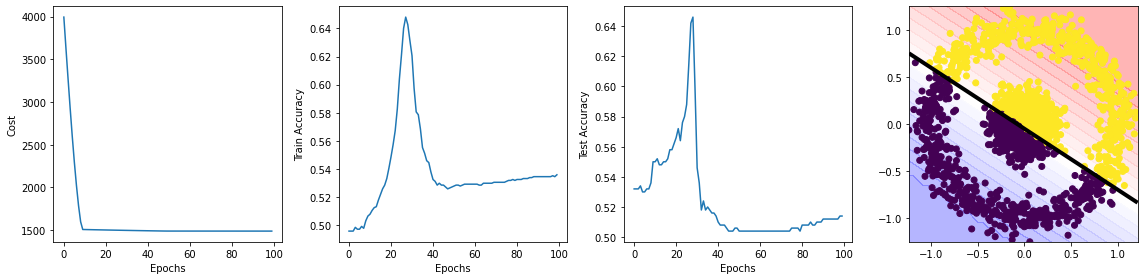

In [9]:
# TODO: plot accuracies, losses and predictions

def plot_dec_boundary(ax, dec_func, X):
    '''
    @Parameters:
        ax... matplotlib axis on which to draw
        dec_func... function that takes feature matrix as input and outputs soft prediction for class
        X... dataset
    '''
    
    # make these smaller to increase the resolution
    dx, dy = 0.05, 0.05

    # generate grids + probs
    x1, x2 = np.mgrid[slice(np.min(X[:,0]), np.max(X[:,0]) + dy, dy), slice(np.min(X[:,1]), np.max(X[:,1]) + dx, dx)]
    points = np.stack([x1.flatten(),x2.flatten()]).T

    decs = dec_func(points).reshape(x1.shape)
    decs[decs>1] = 1
    decs[decs<-1] = -1
    levels = np.arange(-1.1,1.1,1e-1)

    cmap = plt.get_cmap('bwr')
    ax.contourf(x1, x2, decs, cmap=cmap, levels=levels, alpha=0.3)
    ax.contour(x1, x2, decs, levels=[0], colors='black', linewidths=4)
    
fs = 4
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(4*fs, fs))
axs[0].plot(stats['loss'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Cost')
axs[1].plot(stats['accs']['train'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Train Accuracy')
axs[2].plot(stats['accs']['test'])
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Test Accuracy')

preds = predict(X, X_train_svm, w, b)
dec_func = lambda a: decision(a, X_train_svm, w, b)
plot_dec_boundary(axs[3], dec_func, X)
axs[3].scatter(X[:,0], X[:,1], c=preds)

plt.tight_layout()

test_acc = stats['accs']['test'][-1]
train_acc = stats['accs']['train'][-1]
print(f'Test Accuracy: {test_acc}\tTrain Accuracy: {train_acc}')

# The Polynomial kernel

You probably see, why the SVMs performance is limited: Because it is a linear classifier and the data cannot be seperated by a linear regression line. 

This is where kernels come in:

Kernels are functions, that map our features into a higher dimensional space, where they can be seperated by a linear regression line. 
See [here](https://medium.com/@zxr.nju/what-is-the-kernel-trick-why-is-it-important-98a98db0961d) or [here](https://www.youtube.com/watch?v=efR1C6CvhmE) for an explaination with images.

An example would be the *polynomial kernel* of degree 2 that maps a vector onto the vector of its pairwise products:

\begin{align}
\begin{bmatrix}
x_1&x_2
\end{bmatrix}
&\rightarrow
\begin{bmatrix}
x_1^2&x_1x_2&x_2x_1&x_2^2
\end{bmatrix}\\
\begin{bmatrix}
x_1&x_2&x_3
\end{bmatrix}
&\rightarrow
\begin{bmatrix}
x_1^2&x_1x_2&x_1x_3&x_2x_1&x_2^2&x_2x_3&x_3x_1&x_3x_2&x_3^2
\end{bmatrix}
\end{align}

The special property about kernels is the fact that the dot product between two vectors that were produced by the kernel can be calculated directly from the dot products of the original vectors. In other words, if $x_1, x_2$ are features and $\varphi$ is a kernel, then there exists some (simple) function $f$ with

\begin{align}
\varphi(x)^T\varphi(x) = f(x^Tx)
\end{align}

This means, that we can calculate the similarity in a higher dimension without actually having to go into this dimension. This trick is the famous **kernel trick**. In our example of the polynomial kernel of degree 2 we have that

\begin{align}
\varphi_2(x)^T\varphi_2(x) = (x^Tx)^2
\end{align}

And more general, if $p$ is any polynomial degree 

\begin{align}
\varphi_p(x)^T\varphi_p(x) = (x^Tx)^p
\end{align}

### Task 10

Implement $\varphi_p$ for the polynomial kernel of an an arbitrary degree $p$. The function should map an input vector onto the vector of all $p$-wise products.

Hints:
- Use the package [`itertools`](https://docs.python.org/3/library/itertools.html) for index shuffling (see [here](https://stackoverflow.com/questions/104420/how-to-generate-all-permutations-of-a-list))

In [10]:
import itertools
def phi(x, poly):
    # TODO: map x onto vector of poly
    idx = list(np.arange(0,x.shape[0],1))
    idx_list = [idx]*poly
    combinations = list(itertools.product(*idx_list))
    
    ret = []
    for comb in combinations:
        ret.append(np.prod([x[i] for i in comb]))
    return np.array(ret)

### Task 11
Now perform a small experiment:

1. Pick a polynomial degree $p$ and a feature dimension $d$
2. Draw two random vectors $x_1, x_2\in\mathbb{R}^d$
3. Calculate the dot product $\varphi_p(x_1)^T\varphi_p(x_2)$
4. Calculate $(x_1^Tx_2)^p$
5. Compare the results

Hints:
- Compare with [`np.isclose`](https://numpy.org/doc/stable/reference/generated/numpy.isclose.html)

In [11]:
# TODO: Perform experiment
d = 2
poly = 5
for _ in range(1000):
    x1 = np.random.randn(d)
    x2 = np.random.randn(d)
    res1 = np.dot(phi(x1, poly=poly), phi(x2, poly=poly))
    res2 = np.dot(x1,x2)**poly
    assert np.isclose(res1, res2)

### Task 12

Now we want to incorporate this polynomial kernel into our SVM. 
Use your functions from above to fill out the following class. Replace the `sim` function from before with the `kernel` function. This function should calculate the similarity matrix of $\varphi_p(x^{(i)}), \varphi_p(x^{(j)})$ via the kernel trick.

Note: We can immediately see the advantage of defining an algorithm in a class: We do not need to pass all parameters trough the functions, because the functions have access to parameters via the `self` keyword.

In [12]:
class SVMPoly():
    # TODO: Use functions from before to implement 
    def __init__(self, poly, C):
        # TODO: Store algorithm arguments 
        self.poly = poly
        self.C = C
        self.w = None
        self.b = None
        self.X = None
        self.Y = None
        self.pairsim = None
        
    
    def kernel(self, X1, X2):
        # TODO: Implement polynomial kernel
        return (X1 @ X2.T)**self.poly
    
    def decision(self, X):
        # TODO: Implement decision function
        return self.w.dot(self.kernel(self.X, X)) + self.b

    def predict(self, X):
        # TODO: Implement prediction function
        return np.sign(self.decision(X))

    def accuracy(self, X, Y):
        # TODO: Implement accuracy function
        prediction = self.predict(X)
        return np.mean(Y == prediction)

    def margin(self):
        # TODO: Implement margin function
        return self.Y * self.decision(self.X)

    def slack(self):
        # TODO: Implement slack
        return 1-self.margin()

    def cost(self):
        # TODO: Implement cost function
        tmp = sim(self.X, self.X)
        c = (1 / 2) * self.w.dot(tmp.dot(self.w)) + self.C * np.sum(np.maximum(0, self.slack()))
        return c
    
    def grad_b(self):
        # TODO: Implement gradient wrt. b
        slacks = self.slack()
        idx = np.where(slacks>0)[0]
        d_b = - self.C * np.sum(self.Y[idx])
        return d_b

    def grad_w(self):
        # TODO: Implement gradient wrt. w
        slacks = self.slack()
        idx = np.where(slacks>0)[0]
        d_w = self.pairsim.dot(self.w) - self.C * self.Y[idx].dot(self.pairsim[idx])
        return d_w
    
    
    def fit(self, X_train, X_test, Y_train, Y_test, lr=1e-5, epochs=500, eps=1e-3, verbose=False):
        # TODO: Implement fit function
        self.X = X_train
        self.Y = Y_train
        self.pairsim = self.kernel(self.X, self.X)
        train_losses = []
        train_accs = []
        test_accs = []
        
        # Initialize w and b
        self.w = np.random.rand(X_train.shape[0])
        self.b = 0
        
        # Gradient descend
        current_loss = 0
        for it in range(epochs):

            self.w = self.w - lr * self.grad_w()
            self.b = self.b - lr * self.grad_b()
 
            loss_train = self.cost()
            acc_train = self.accuracy(X_train, Y_train)
            acc_test = self.accuracy(X_test, Y_test)
 
            train_losses.append(loss_train)
            train_accs.append(acc_train)
            test_accs.append(acc_test)
            
            if abs(current_loss-train_losses[-1])<eps:
                
                break
            current_loss = train_losses[-1]
            
            
        
        stats = {
            'loss': train_losses,
            'accs': {
                'test': test_accs,
                'train': train_accs
            }
        }
        return stats
    

### Task 13
Now use the `SVMPoly` class to fit an SVM on our train data.
Again plot the accuracies and losses as well as the predictions on the dataset.

Test Accuracy: 1.0	Train Accuracy: 1.0


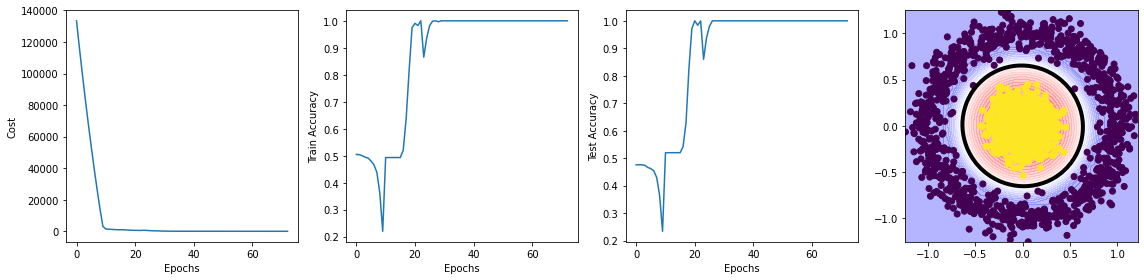

In [14]:
# TODO: fit on train data
polysvm = SVMPoly(poly = 2, C=1.0)
stats = polysvm.fit(X_train_svm, X_test_svm, Y_train_svm, Y_test_svm, lr=1e-4, epochs=200, eps=1e-2)

# TODO: plot accuracies, losses and predictions
fs = 4
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(4*fs, fs))
axs[0].plot(stats['loss'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Cost')
axs[1].plot(stats['accs']['train'])
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Train Accuracy')
axs[2].plot(stats['accs']['test'])
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Test Accuracy')


plot_dec_boundary(axs[3], polysvm.decision, X)
preds = polysvm.predict(X)
axs[3].scatter(X[:,0], X[:,1], c=preds)

plt.tight_layout()
test_acc = stats['accs']['test'][-1]
train_acc = stats['accs']['train'][-1]
print(f'Test Accuracy: {test_acc}\tTrain Accuracy: {train_acc}')

### Task 14

Compare your results with the [Scikit learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

Test Accuracy: 1.0	Train Accuracy: 1.0


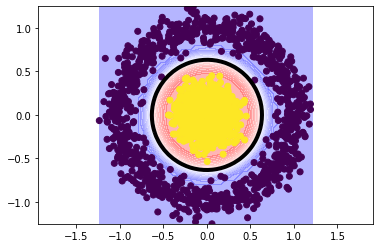

In [16]:
# TODO: Use sklearn to fit svm on traindata
from sklearn import svm
clf = svm.SVC(kernel='poly', degree=2)
clf.fit(X_train_svm, Y_train_svm)

# TODO: Plot predictions, calculate test accuracy
plot_dec_boundary(plt.gca(), clf.decision_function, X)
preds = clf.predict(X)
plt.scatter(X[:,0], X[:,1], c=preds)
test_acc = np.mean(clf.predict(X_test_svm)==Y_test_svm)
train_acc = np.mean(clf.predict(X_train_svm)==Y_train_svm)
plt.axis('equal')
print(f'Test Accuracy: {test_acc}\tTrain Accuracy: {train_acc}')

### Creation of dataset (Just for me)

In [1]:
from sklearn import datasets

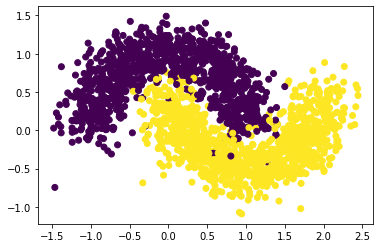

In [4]:
noisy_moons = datasets.make_moons(n_samples=2000, noise=0.2, random_state=6)
X = noisy_moons[0]
Y = noisy_moons[1]
plt.scatter(X[:,0], X[:,1], c=Y)
np.save('X.npy', X)
np.save('Y.npy', Y)

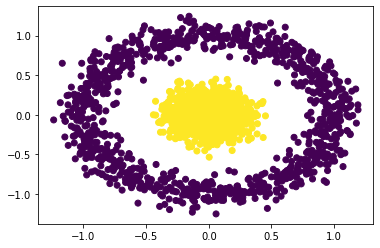

In [27]:
noisy_circles = datasets.make_circles(n_samples=2000, factor=0.2, noise=0.1)
X = noisy_circles[0]
Y = noisy_circles[1]
plt.scatter(X[:,0], X[:,1], c=Y)
np.save('X.npy', X)
np.save('Y.npy', Y)